In [1]:
import torch
import torch.nn.functional as F
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import tifffile as tiff
import cv2

In [2]:
data_path = Path("../data/")
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv']

In [3]:
train_images_path = data_path / "train_images"

In [4]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## View sample

In [5]:
idx = randint(0, len(train_df) - 1)

In [6]:
sample_img_path = train_df.iloc[idx].path
sample_img_path

'../data/train_images/5317.tiff'

In [7]:
sample_img_tiff = tiff.imread(sample_img_path)
type(sample_img_tiff), sample_img_tiff.shape, sample_img_tiff.dtype, sample_img_tiff.min(), sample_img_tiff.max()

(numpy.ndarray, (2416, 2416, 3), dtype('uint8'), 8, 255)

In [8]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [9]:
sample_img_tiff_mask = rle2mask(train_df.iloc[idx].rle, sample_img_tiff.shape)
type(sample_img_tiff_mask), sample_img_tiff_mask.shape, sample_img_tiff_mask.dtype, sample_img_tiff_mask.min(), sample_img_tiff_mask.max()

(numpy.ndarray, (2416, 2416), dtype('uint8'), 0, 1)

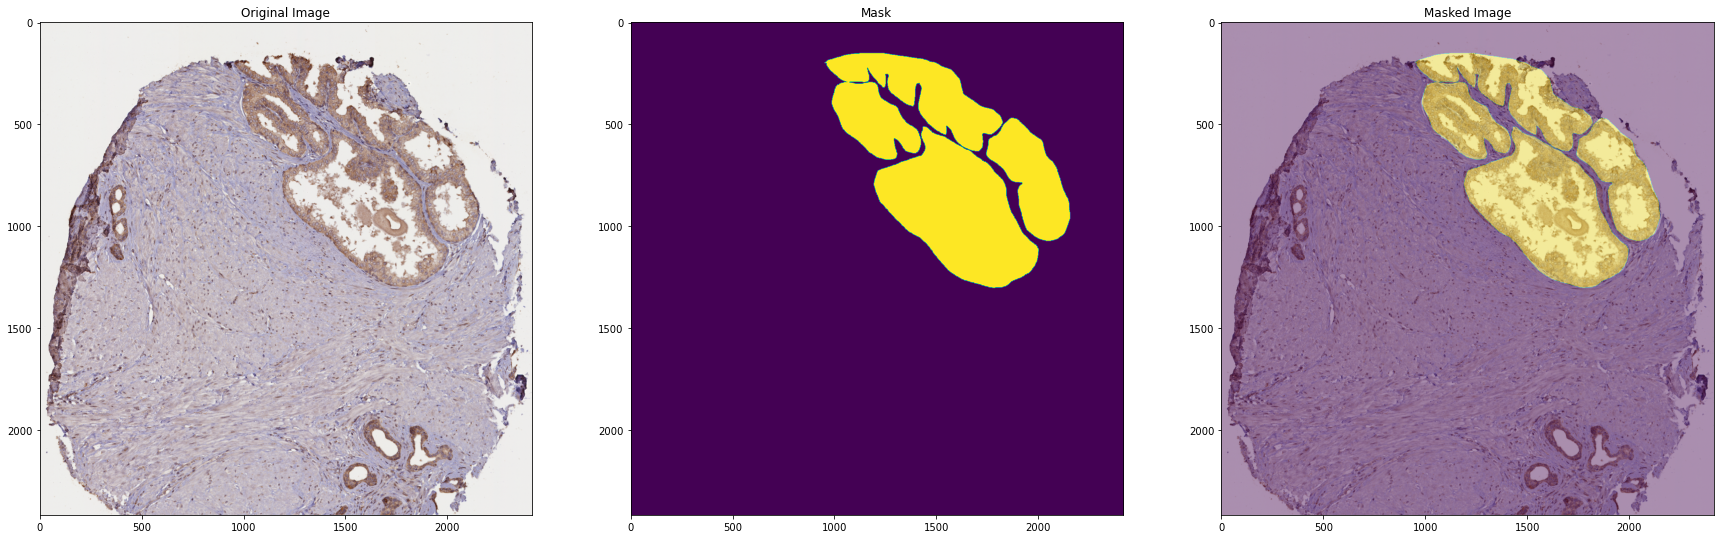

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_tiff)
ax1.set_title('Original Image')
ax2.imshow(sample_img_tiff_mask)
ax2.set_title('Mask')
ax3.imshow(sample_img_tiff)
ax3.imshow(sample_img_tiff_mask, alpha=0.4)
ax3.set_title('Masked Image')
plt.show()

In [11]:
sample_img_tiff_mask_oh = np.eye(2)[sample_img_tiff_mask.astype(int)].astype(np.float32)
type(sample_img_tiff_mask_oh), sample_img_tiff_mask_oh.shape, sample_img_tiff_mask_oh.dtype, sample_img_tiff_mask_oh.min(), sample_img_tiff_mask_oh.max()

(numpy.ndarray, (2416, 2416, 2), dtype('float32'), 0.0, 1.0)

## Resize image

In [12]:
sample_img_cv = cv2.imread(sample_img_path)
sample_img_cv = cv2.cvtColor(sample_img_cv, cv2.COLOR_BGR2RGB)
dim = 2000
reshape = (dim, dim)
tipe = cv2.INTER_LANCZOS4
sample_img_cv_res = cv2.resize(sample_img_cv, dsize=reshape, interpolation=tipe)
type(sample_img_cv_res), sample_img_cv_res.shape, sample_img_cv_res.dtype, sample_img_cv_res.min(), sample_img_cv_res.max()

(numpy.ndarray, (2000, 2000, 3), dtype('uint8'), 9, 255)

In [13]:
sample_img_cv_mask = rle2mask(train_df.iloc[idx].rle, sample_img_cv.shape)
sample_img_cv_mask_res = cv2.resize(sample_img_cv_mask, dsize=reshape, interpolation=tipe)
type(sample_img_cv_mask_res), sample_img_cv_mask_res.shape, sample_img_cv_mask_res.dtype, sample_img_cv_mask_res.min(), sample_img_cv_mask_res.max()

(numpy.ndarray, (2000, 2000), dtype('uint8'), 0, 1)

In [14]:
sample_img_cv_mask_oh = np.eye(2)[sample_img_cv_mask_res.astype(int)].astype(np.float32)
type(sample_img_cv_mask_oh), sample_img_cv_mask_oh.shape, sample_img_cv_mask_oh.dtype, sample_img_cv_mask_oh.min(), sample_img_cv_mask_oh.max()

(numpy.ndarray, (2000, 2000, 2), dtype('float32'), 0.0, 1.0)

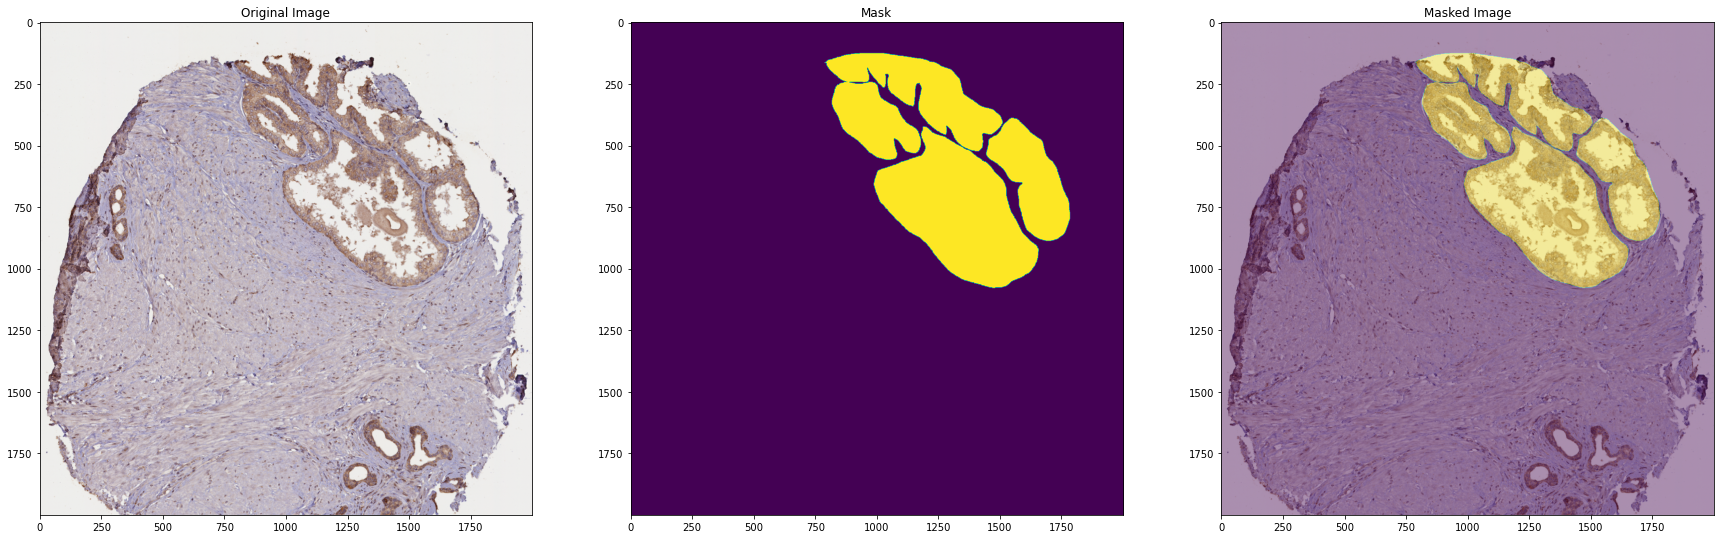

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_cv_res)
ax1.set_title('Original Image')
ax2.imshow(sample_img_cv_mask_res)
ax2.set_title('Mask')
ax3.imshow(sample_img_cv_res)
ax3.imshow(sample_img_cv_mask_res, alpha=0.4)
ax3.set_title('Masked Image')
plt.show()

## UNet from scratch

In [16]:
number_of_classes = sample_img_tiff_mask.max() + 1 # 2 classes
number_of_channels = 3

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=number_of_classes, in_ch=number_of_channels):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

try model with random tensor

In [17]:
model = UNet()
output = model(torch.randn((10,3,300,300)))
output.shape

torch.Size([10, 2, 300, 300])

## Fit of one sample

In [18]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit(model, X, y, epochs=1, lr=3e-4, parallel=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if parallel:
        model = torch.nn.DataParallel(model)
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [19]:
sample_img_tensor = torch.from_numpy(sample_img_cv_res).float()
print(sample_img_tensor.shape, sample_img_tensor.dtype, sample_img_tensor.min(), sample_img_tensor.max())
sample_img_tensor = sample_img_tensor.permute(2, 0, 1)
print(sample_img_tensor.shape, sample_img_tensor.dtype, sample_img_tensor.min(), sample_img_tensor.max())
sample_img_tensor = sample_img_tensor.unsqueeze(0)
print(sample_img_tensor.shape, sample_img_tensor.dtype, sample_img_tensor.min(), sample_img_tensor.max())

torch.Size([2000, 2000, 3]) torch.float32 tensor(9.) tensor(255.)
torch.Size([3, 2000, 2000]) torch.float32 tensor(9.) tensor(255.)
torch.Size([1, 3, 2000, 2000]) torch.float32 tensor(9.) tensor(255.)


In [20]:
sample_img_tiff_mask_tensor = torch.from_numpy(sample_img_cv_mask_oh).float()
print(sample_img_tiff_mask_tensor.shape, sample_img_tiff_mask_tensor.dtype, sample_img_tiff_mask_tensor.min(), sample_img_tiff_mask_tensor.max())
sample_img_tiff_mask_tensor = sample_img_tiff_mask_tensor.permute(2, 0, 1)
print(sample_img_tiff_mask_tensor.shape, sample_img_tiff_mask_tensor.dtype, sample_img_tiff_mask_tensor.min(), sample_img_tiff_mask_tensor.max())
sample_img_tiff_mask_tensor = sample_img_tiff_mask_tensor.unsqueeze(0)
print(sample_img_tiff_mask_tensor.shape, sample_img_tiff_mask_tensor.dtype, sample_img_tiff_mask_tensor.min(), sample_img_tiff_mask_tensor.max())

torch.Size([2000, 2000, 2]) torch.float32 tensor(0.) tensor(1.)
torch.Size([2, 2000, 2000]) torch.float32 tensor(0.) tensor(1.)
torch.Size([1, 2, 2000, 2000]) torch.float32 tensor(0.) tensor(1.)


In [21]:
fit(model, sample_img_tensor, sample_img_tiff_mask_tensor, epochs=50, parallel=True)

Epoch 0/50 loss 0.74909
Epoch 1/50 loss 0.72936
Epoch 2/50 loss 0.71421
Epoch 3/50 loss 0.70030
Epoch 4/50 loss 0.68726
Epoch 5/50 loss 0.67519
Epoch 6/50 loss 0.66387
Epoch 7/50 loss 0.65299
Epoch 8/50 loss 0.64252
Epoch 9/50 loss 0.63237
Epoch 10/50 loss 0.62262
Epoch 11/50 loss 0.61318
Epoch 12/50 loss 0.60401
Epoch 13/50 loss 0.59517
Epoch 14/50 loss 0.58643
Epoch 15/50 loss 0.57785
Epoch 16/50 loss 0.56935
Epoch 17/50 loss 0.56103
Epoch 18/50 loss 0.55280
Epoch 19/50 loss 0.54466
Epoch 20/50 loss 0.53665
Epoch 21/50 loss 0.52899
Epoch 22/50 loss 0.52280
Epoch 23/50 loss 0.51434
Epoch 24/50 loss 0.50806
Epoch 25/50 loss 0.49969
Epoch 26/50 loss 0.49366
Epoch 27/50 loss 0.48627
Epoch 28/50 loss 0.47878
Epoch 29/50 loss 0.47285
Epoch 30/50 loss 0.46529
Epoch 31/50 loss 0.45917
Epoch 32/50 loss 0.45262
Epoch 33/50 loss 0.44572
Epoch 34/50 loss 0.43951
Epoch 35/50 loss 0.43301
Epoch 36/50 loss 0.42664
Epoch 37/50 loss 0.42069
Epoch 38/50 loss 0.41419
Epoch 39/50 loss 0.40893
Epoch 40/5

## Using Dice coefficient loss

In [33]:
def dice_coeff(pred, target):
    smooth = 0.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

In [36]:
def fit(model, X, y, epochs=1, lr=1e-3, parallel=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if parallel:
        model = torch.nn.DataParallel(model)
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        dice = dice_coeff(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} dice {dice:.5f}")

In [37]:
fit(model, sample_img_tensor, sample_img_tiff_mask_tensor, epochs=50, parallel=True)

Epoch 1/50 loss 0.12058 dice 8.13434
Epoch 2/50 loss 0.15610 dice 7.81552
Epoch 3/50 loss 0.12497 dice 8.33002
Epoch 4/50 loss 0.10445 dice 8.82168
Epoch 5/50 loss 0.10975 dice 9.03635
Epoch 6/50 loss 0.10547 dice 9.20597
Epoch 7/50 loss 0.09653 dice 9.37777
Epoch 8/50 loss 0.08805 dice 9.55075
Epoch 9/50 loss 0.08563 dice 9.69277
Epoch 10/50 loss 0.08139 dice 9.90262
Epoch 11/50 loss 0.07734 dice 10.15797
Epoch 12/50 loss 0.07145 dice 10.44172
Epoch 13/50 loss 0.06881 dice 10.70499
Epoch 14/50 loss 0.06510 dice 10.97056
Epoch 15/50 loss 0.06285 dice 11.19266
Epoch 16/50 loss 0.05986 dice 11.40017
Epoch 17/50 loss 0.05733 dice 11.60174
Epoch 18/50 loss 0.05392 dice 11.83404
Epoch 19/50 loss 0.05199 dice 12.06136
Epoch 20/50 loss 0.04913 dice 12.25898
Epoch 21/50 loss 0.04757 dice 12.44428
Epoch 22/50 loss 0.04585 dice 12.65965
Epoch 23/50 loss 0.04321 dice 12.87655
Epoch 24/50 loss 0.04202 dice 13.03912
Epoch 25/50 loss 0.04149 dice 13.24824
Epoch 26/50 loss 0.03893 dice 13.36341
Epoch

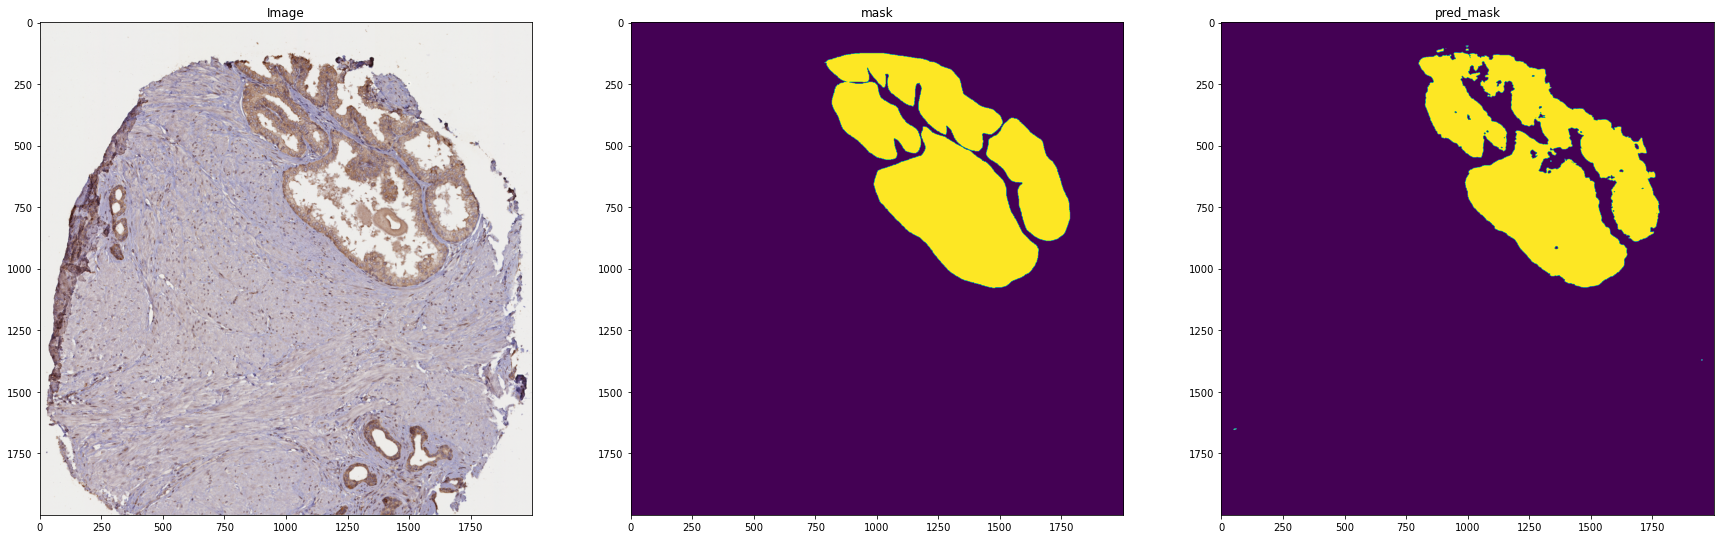

output.shape = torch.Size([2, 2000, 2000]), pred_mask.shape = torch.Size([2000, 2000])


In [39]:
model.eval()
with torch.no_grad():
    output = model(sample_img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_cv_res)
ax1.set_title('Image')
ax2.imshow(sample_img_cv_mask_res)
ax2.set_title('mask')
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.set_title('pred_mask')
plt.show()
print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")

## Train all images

In [96]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(sample_img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Convert to tensor
    img_tensor = torch.from_numpy(sample_img_cv_res).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [104]:
division = 300
dataset = {
    'train': Dataset(train_df[:division], n_classes=2, dim=2000),
    'val': Dataset(train_df[division:], n_classes=2, dim=2000),
}

print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 300 imágenes de entrenamiento y 51 imágenes de validación


In [105]:
BS_train = 4
BS_val = 16
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

In [106]:
sample_train_img, sample_train_mask = next(iter(dataloader['train']))
sample_val_img, sample_val_mask = next(iter(dataloader['test']))

sample_train_img.shape, sample_train_mask.shape

(torch.Size([4, 3, 2000, 2000]), torch.Size([4, 2, 2000, 2000]))

In [ ]:
# from tqdm import tqdm

# def fit(model, dataloader, epochs=100, lr=3e-4):
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     criterion = torch.nn.BCEWithLogitsLoss()
#     model.to(device)
#     hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
#     for epoch in range(1, epochs+1):
#       bar = tqdm(dataloader['train'])
#       train_loss, train_iou = [], []
#       model.train()
#       for imgs, masks in bar:
#         imgs, masks = imgs.to(device), masks.to(device)
#         optimizer.zero_grad()
#         y_hat = model(imgs)
#         loss = criterion(y_hat, masks)
#         loss.backward()
#         optimizer.step()
#         ious = iou(y_hat, masks)
#         train_loss.append(loss.item())
#         train_iou.append(ious)
#         bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
#       hist['loss'].append(np.mean(train_loss))
#       hist['iou'].append(np.mean(train_iou))
#       bar = tqdm(dataloader['test'])
#       test_loss, test_iou = [], []
#       model.eval()
#       with torch.no_grad():
#         for imgs, masks in bar:
#           imgs, masks = imgs.to(device), masks.to(device)
#           y_hat = model(imgs)
#           loss = criterion(y_hat, masks)
#           ious = iou(y_hat, masks)
#           test_loss.append(loss.item())
#           test_iou.append(ious)
#           bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
#       hist['test_loss'].append(np.mean(test_loss))
#       hist['test_iou'].append(np.mean(test_iou))
#       print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
#     return hist

In [ ]:
# model = UNet()
# hist = fit(model, dataloader, epochs=30)

In [ ]:
# df = pd.DataFrame(hist)
# df.plot(grid=True)
# plt.show()